In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from numpy import exp, log, e
from scipy.optimize import curve_fit
%matplotlib notebook

# Simulate Decay

In [31]:
def lambertDecay(t, tau, sigma_12, sigma_21, n, n20, r, rho, d):
    alpha = (1+r/2)
    A = alpha*rho*d*(sigma_12+sigma_21)
    B = 1 + alpha*rho*d*sigma_12*n

    x = (t/(B*tau)) + (A*n20)
    arg = -A*n20*exp(-x)/B

    # Check that result is real
    assert min(arg) >= -1/e, \
        'Lambert W Argument will give an imaginary result.'

    return -B*lambertw(arg).real/A

In [3]:
def decayTime(t, tau, sigma_12, sigma_21, n, n20, r, rho, d):

    def model_func(t, a, b, c):
        return a*np.exp(-t/b)+c

    y = lambertDecay(t, tau, sigma_12, sigma_21, n, n20, r, rho, d)

    guess = [max(y)-min(y), tau, 0]  # Guess for a, b, c coefficients
    popt, pcov = curve_fit(model_func, t, y, guess)   # Fit using Levenberg-Marquardt algorithm
    decay = popt[1]         # Lifetime (ms)

    return decay

In [115]:
# Time to simulate over
t = np.linspace(0, 100, num=100)

# Define material parameters:
rho = 0.91          # Density of Er ions (*1E21 cm^-3)
tau = 10            # Radiative decay rate
d = 1E-4            # Thickness of deposition (cm)
sigma_12 = 4.1      # Absorption cross-section (*1E-21 cm^2)
sigma_21 = 5        # Emission cross-section (*1E-21 cm^2)
n = 1               # Total number of active ions (i.e.,clustering)

In [116]:
# Amplify effects
d *= 50

<IPython.core.display.Javascript object>


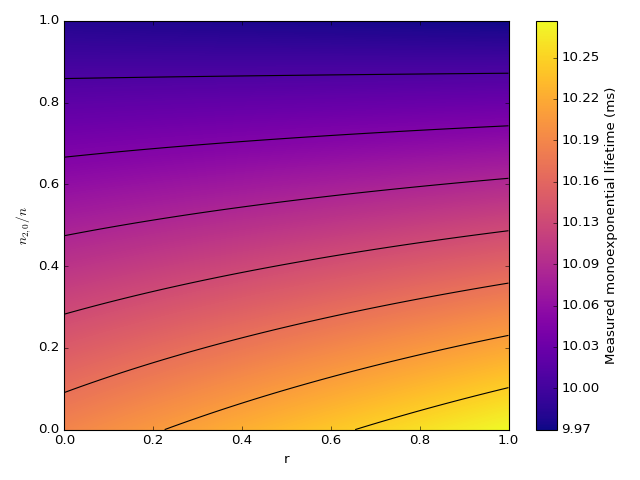

In [117]:
x = np.linspace(1E-4, 1, 50)      # r list
y = np.linspace(1E-4, n, 50)     # n20 list
X, Y = np.meshgrid(x, y)

zs = np.array([decayTime(t, tau, sigma_12, sigma_21, n, n20, r, rho, d)
               for r, n20 in zip(np.ravel(X), np.ravel(Y))])

Z = zs.reshape(X.shape)

origin = 'lower'
lv = 1000  # Levels of colours
st = int(lv/10) # Plot 10 contour lines

plt.figure()
CS = plt.contourf(X, Y, Z, 
                  lv,
                  cmap=plt.cm.plasma,
                  origin=origin)

CS2 = plt.contour(CS,
                  levels=CS.levels[::st],
                  colors='k',
                  origin=origin,
                  hold='on')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = plt.colorbar(CS, format='%.2f')
# cbar.formatter.set_useOffset(False)
cbar.update_ticks()

# Add the contour line levels to the colorbar
# cbar.add_lines(CS2)

plt.xlabel('r')
plt.ylabel('$n_{2,0}/n$')
cbar.ax.set_ylabel('Measured monoexponential lifetime (ms)')
plt.tight_layout()
# plt.savefig('Images/contour_model.png', dpi=500)

# Lambert-W function

C:\Users\mn14tm\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


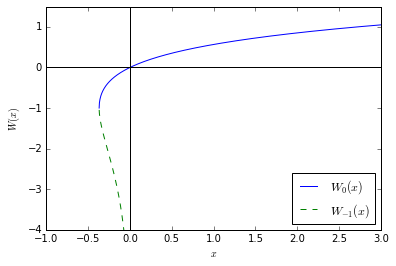

In [17]:
x0 = np.linspace(-1/e,3, 1000)
y0 = lambertw(x0)
x1 = np.linspace(-1/e, 0, 1000)
y1 = lambertw(x1,-1)


plt.plot(x0,y0,label='$W_0(x)$')
plt.plot(x1,y1, '--',label='$W_{-1}(x)$')
plt.xlim(-1,3)
plt.ylim(-4, 1.5)
plt.xlabel('$x$')
plt.ylabel('$W(x)$')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.legend(loc='best')
plt.savefig('lambertW.png', dpi=600)

# Misc

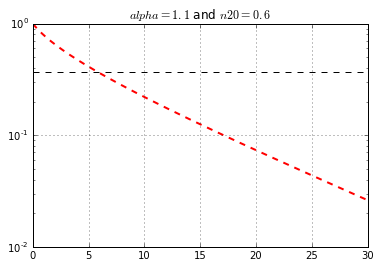

In [4]:
from ipywidgets import interact

def plt_arrays(x, y, title="", color="red", linestyle="dashed", linewidth=2):
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.plot(x,y, color=color, linestyle=linestyle, linewidth=linewidth)
    axes.set_title(title)
    axes.grid()
    plt.axhline(1/np.e, ls='--', color='k')
    plt.xlim(0,30)
    plt.yscale('log')
    plt.show()
    
def f(alpha, n20, **kwargs):
    t = np.linspace(0,30,500)
    tau = 10
    sigma_21 = 1
    n = lambertDecay(t, alpha, tau, sigma_21, n20)
    
    title="$alpha = %s$ and $n20 = %s$" % (alpha,n20)
    
    plt_arrays(t,n/max(n), title=title, **kwargs)
    
#Define Constants
alpha=0.25
n20=0.7

f(alpha, n20)

i = interact(f,
             alpha=(0.1,10.),
             n20=(0.5,1),
#              color = ["red", "blue", "green"],
#              linestyle=["solid", "dashed"],
#              linewidth=(1,5)
             )

<IPython.core.display.Javascript object>


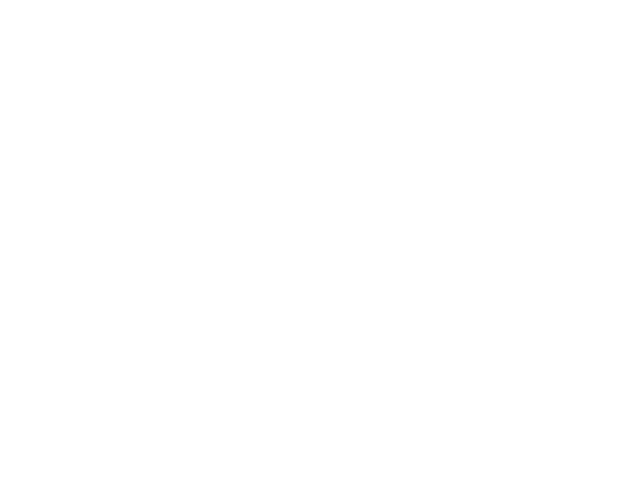

ValueError: x, y and z must be equal-length 1-D arrays

In [15]:
import matplotlib.mlab as ml
x = np.linspace(1E-4, 1, 20)     # r
y = np.linspace(1E-4, n, 20)     # n20
X, Y = np.meshgrid(x, y)
z = np.array([decayTime(t, tau, sigma_12, sigma_21, n, n20, r, rho, d)
               for r, n20 in zip(np.ravel(X), np.ravel(Y))])

fig, ax = plt.subplots()
xi = np.linspace(min(x), 100, len(x))
yi = np.linspace(min(y), max(y), len(y))
zi = ml.griddata(x, y, z, xi, yi, interp='linear')

plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
plt.pcolormesh(xi, yi, zi, cmap=plt.get_cmap('plasma'))
plt.colorbar(label='Lifetime (ms)')
plt.scatter(x, y, marker='o', c='b', s=5, zorder=10)
plt.xlim(min(x), 100)
plt.ylim(min(y), max(y))
ax.set_xlabel('% Reflectance')
ax.set_ylabel('Current (A)')

<IPython.core.display.Javascript object>


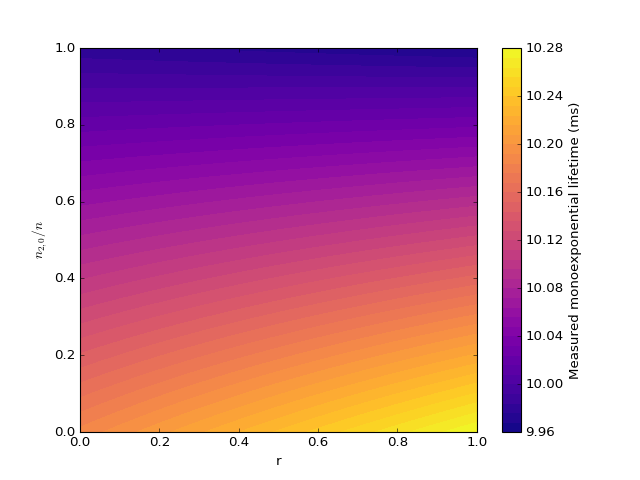

In [16]:
x = np.linspace(1E-4, 1, 20)     # r
y = np.linspace(1E-4, n, 20)     # n20
X, Y = np.meshgrid(x, y)

zs = np.array([decayTime(t, tau, sigma_12, sigma_21, n, n20, r, rho, d)
               for r, n20 in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

origin = 'lower'
# origin = 'upper'
lv = 40  # Levels of colours

plt.figure()
CS = plt.contourf(X, Y, Z, lv,
                  # levels=np.arange(0, 100, 5),
                  cmap=plt.cm.plasma,
                  origin=origin)

# CS2 = plt.contour(CS,
#                   levels=CS.levels[::4],
#                   colors='k',
#                   origin=origin,
#                   hold='on')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = plt.colorbar(CS)
cbar.formatter.set_useOffset(False)
cbar.update_ticks()

# Add the contour line levels to the colorbar
# cbar.add_lines(CS2)

plt.xlabel('r')
plt.ylabel('$n_{2,0}/n$')
cbar.ax.set_ylabel('Measured monoexponential lifetime (ms)')

# plt.savefig('Images/contourfplot.png', dpi=900)